In [0]:
!pip install gensim

In [0]:
import os
import re

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout
from keras.layers import SpatialDropout1D, Conv1D, MaxPooling1D
from gensim.models import Word2Vec
from keras.utils import np_utils
from keras.preprocessing import sequence
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
import seaborn as sns
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
w2v_path = os.path.join("/content/gdrive/My Drive/", "Colab Notebooks/ruwikiruscorpora-nobigrams_upos_skipgram_300_5_2018.vec.gz")
hh_data_path = os.path.join("/content/gdrive/My Drive/", "Colab Notebooks/hh_dataset.csv")

In [0]:
dataset_hh = pd.read_csv(hh_data_path, sep="\t")
dataset_hh = dataset_hh.loc[dataset_hh["lang_text"] != "english"]
#dataset_hh.drop(dataset_hh.index[dataset_hh["lang_text"] == "english"], inplace=True)
dataset_hh.reset_index(drop=True, inplace=True)

In [127]:
dataset_hh.head()

,id,lang_title,requirement,requirement_lemmas,requirement_lemmas_tags,requirement_norm,requirement_tokens,responsibility,responsibility_lemmas,responsibility_lemmas_tags,...,title_tokens,url,lang_text,profarea_names,specializations,text,text_lemmas,text_lemmas_tags,text_normalized,text_tokens
0,29103667,russian,Высшее (желательно техническое) образование. П...,высший желательный технический образование lot...,высший_ADJ желательный_ADJ технический_ADJ обр...,высш желательн техническ образован lotus хорош...,высшее желательно техническое образование lotu...,Ежедневное планирование работы завода (молочно...,ежедневный планирование работа завод молочный ...,ежедневный_ADJ планирование_NOUN работа_NOUN з...,...,специаидать_NOUN планирование_NOUN производств...,https://api.hh.ru/vacancies/29103667?host=hh.ua,russian,"['Производство', 'Закупки']","['Пищевая промышленность', 'Управление закупка...",<p><strong>Международная компания – крупнейший...,международный компания крупнейший производител...,международный_ADJ компания_NOUN крупнейший_ADJ...,международн компан крупн производител свеж мол...,международный_ADJ компания_NOUN крупнейший_ADJ...
1,29103666,russian,Умение работать в коллективе. Образование не н...,умение работать коллектив образование ниже тех...,умение_NOUN работать_VERB коллектив_NOUN образ...,умен работа коллектив образован ниж техническ ...,умение работать коллективе образование ниже те...,Техническая подготовка выполнения сварочных ра...,технический подготовка выполнение сварочный ра...,технический_ADJ подготовка_NOUN выполнение_NOU...,...,главный_ADJ сварщик_NOUN,https://api.hh.ru/vacancies/29103666?host=hh.ua,russian,['Рабочий персонал'],['Сварщик'],<strong>Обязанности:</strong> <ul> <li><em>Тех...,обязанность технический подготовка выполнение ...,обязанность_NOUN технический_ADJ подготовка_NO...,обязан техническ подготовк выполнен сварочн ра...,обязанность_NOUN технический_ADJ подготовка_NO...
2,29103664,russian,Профильное высшее образование (Художественное/...,профильный высший образование креативность нес...,профильный_ADJ высший_ADJ образование_NOUN кре...,профильн высш образован креативн нестандартн м...,профильное высшее образование креативность нес...,Дизайн и верстка еженедельного акционного букл...,дизайн верстка еженедельный акциоть буклет раз...,дизайн_NOUN верстка_NOUN еженедельный_ADJ акци...,...,дизайнер_NOUN,https://api.hh.ru/vacancies/29103664?host=hh.ua,russian,"['Искусство, развлечения, масс-медиа', 'Маркет...","['Дизайн, графика, живопись', 'Дизайнер']",<p><strong>Сеть гипермаркетов ProStore приглаш...,сеть гипермаркет prostore приглашать постоянны...,сеть_NOUN гипермаркет_NOUN prostore_X приглаша...,сет гипермаркет prostor приглаша постоя работ ...,сеть_NOUN гипермаркет_NOUN prostore_X приглаша...
3,29103661,russian,1. Высшее образование ( в приоритете: менеджме...,высший образование приоритет менеджмент маркет...,высший_ADJ образование_NOUN приоритет_VERB мен...,высш образован приоритет менеджмент маркетинг ...,высшее образование приоритете менеджмент марке...,Наша студия помогает компаниям повышать продаж...,наш студия помогать компания повышать продажа ...,наш_DET студия_NOUN помогать_VERB компания_NOU...,...,руководитель_NOUN отдел_NOUN продажа_NOUN,https://api.hh.ru/vacancies/29103661?host=hh.ua,russian,"['Продажи', 'Продажи', 'Высший менеджмент']","['Услуги для бизнеса', 'Управление продажами',...",<p>Наша студия помогает компаниям повышать про...,наш студия помогать компания повышать продажа ...,наш_DET студия_NOUN помогать_VERB компания_NOU...,наш студ помога компан повыша продаж помощ про...,наш_DET студия_NOUN помогать_VERB компания_NOU...
4,29103660,russian,Требования: Опыт работы по специальности обяза...,требование опыт работа специальность обязатель...,требование_NOUN опыт_NOUN работа_NOUN специаль...,требован оп работ специальн обязател желательн...,требования опыт работы специальности обязателе...,Обязанности: Заточка и доводка режущего инстру...,обязанность заточка доводка рез

In [128]:
dataset_hh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588 entries, 0 to 3587
Data columns (total 26 columns):
id                            3588 non-null int64
lang_title                    3588 non-null object
requirement                   3472 non-null object
requirement_lemmas            3472 non-null object
requirement_lemmas_tags       3472 non-null object
requirement_norm              3472 non-null object
requirement_tokens            3472 non-null object
responsibility                3409 non-null object
responsibility_lemmas         3409 non-null object
responsibility_lemmas_tags    3409 non-null object
responsibility_norm           3409 non-null object
responsibility_tokens         3409 non-null object
title                         3588 non-null object
title_lemmas                  3270 non-null object
title_lemmas_tags             3270 non-null object
title_normalized              3270 non-null object
title_tokens                  3270 non-null object
url                        

### Prapare data to rnn

In [0]:
vectorizer = KeyedVectors.load_word2vec_format(w2v_path, binary=False)


In [129]:
labels = []
for i, row in dataset_hh.iterrows():
    specs = row["profarea_names"].lower()
    specs = specs.split("', ") 
    for spec in specs: 
        spec = re.sub('[\[\'\]]', '', spec)
        labels.append(spec.strip())

labels = list(set(labels))

print("Labels number:", len(labels))
print("Labels:", labels)

Labels number: 28
Labels: ['консультирование', 'безопасность', 'закупки', 'бухгалтерия, управленческий учет, финансы предприятия', 'туризм, гостиницы, рестораны', 'продажи', 'автомобильный бизнес', 'высший менеджмент', 'наука, образование', 'инсталляция и сервис', 'информационные технологии, интернет, телеком', 'транспорт, логистика', 'государственная служба, некоммерческие организации', 'банки, инвестиции, лизинг', 'добыча сырья', 'маркетинг, реклама, pr', 'строительство, недвижимость', 'спортивные клубы, фитнес, салоны красоты', 'медицина, фармацевтика', 'юристы', 'управление персоналом, тренинги', 'страхование', 'рабочий персонал', 'начало карьеры, студенты', 'искусство, развлечения, масс-медиа', 'административный персонал', 'производство', 'домашний персонал']


In [0]:
def vectorize_text(text, vectorizer, max_len):
    """
    :param str text: normalized text
    :param Word2Vec vectorizer:
    :param int max_len:
    :return np.array text_vect: of shape like (1, max_len, 100)
    """
    text_vect = []
    words = text.split(" ")
    for word in words:
        try:
            word_vect = vectorizer.word_vec(word)
            text_vect.append(word_vect)
        except KeyError:
            None
      
    np.array(text_vect)
    text_vect = np.reshape(text_vect, (1, -1, 100))
    text_vect = sequence.pad_sequences(text_vect, maxlen=max_len, dtype='float')
            
    return text_vect
    

In [0]:

n_classes = len(labels)
n_examples = len(dataset_hh)
X = []
Y = np.zeros((n_examples, n_classes))
for i, row in dataset_hh.iterrows():
    X.append([])
    words = row["text_lemmas_tags"].split(" ")
    for word in words:
        try:
            word_vec = vectorizer.word_vec(word)
            X[i].append(word_vec)
        except KeyError:
            None
     
    
    specs = row["profarea_names"].lower() 
    specs = specs.split("', ") 
    for spec in specs: 
        spec = re.sub('[\[\'\]]', '', spec)
        pos = labels.index(spec.strip())
        Y[i][pos] = 1
        
assert(len(X) == len(Y))


In [171]:
max_len = max([len(i) for i in X])
print("Max len =", max_len)
max_len = 300
print("Max len edited=", max_len)

Max len = 689
Max len edited= 300


In [0]:
#X = sequence.pad_sequences(X, maxlen=max_len, dtype='float')

In [172]:
print(len(X))
print(Y.shape)

3588
(3588, 28)


In [0]:
def get_classes(y_one_hot, labels, threshold=0.5):
    """
    :param np.array y_one_hot: shape like (1, n_classes)
    :param list of str labels:
    :return list of str classes: 
    """
    classes = []
    y_rounded = np.zeros(y_one_hot.shape)
    y_rounded[y_one_hot > threshold] = 1
    for i in range(len(labels)):
        if y_rounded[0][i] == 1:
            classes.append(labels[i])
            
    return classes
        

In [174]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=100)
print(len(X_train))
#print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

2511
(2511, 28)
(1077, 28)


In [175]:
counts = []
for i in range(len(labels)):
    print(' Species {} appears {} times'.format(labels[i], np.sum(Y_train[:,i]) + np.sum(Y_test[:,i])))
    counts.append(np.sum(Y_train[:,i]) + np.sum(Y_test[:,i]))
print('###')
all_y = np.concatenate([Y_train, Y_test])
all_sum_y = np.sum(all_y, axis=1)
print('As a mean {} species appear on each recording (standard deviation {})'.format(np.mean(all_sum_y), np.std(all_sum_y)))

 Species консультирование appears 226.0 times
 Species безопасность appears 28.0 times
 Species закупки appears 46.0 times
 Species бухгалтерия, управленческий учет, финансы предприятия appears 192.0 times
 Species туризм, гостиницы, рестораны appears 289.0 times
 Species продажи appears 1411.0 times
 Species автомобильный бизнес appears 127.0 times
 Species высший менеджмент appears 53.0 times
 Species наука, образование appears 59.0 times
 Species инсталляция и сервис appears 25.0 times
 Species информационные технологии, интернет, телеком appears 483.0 times
 Species транспорт, логистика appears 283.0 times
 Species государственная служба, некоммерческие организации appears 5.0 times
 Species банки, инвестиции, лизинг appears 288.0 times
 Species добыча сырья appears 6.0 times
 Species маркетинг, реклама, pr appears 299.0 times
 Species строительство, недвижимость appears 272.0 times
 Species спортивные клубы, фитнес, салоны красоты appears 78.0 times
 Species медицина, фармацевтика

In [176]:
counts[15]

299.0

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


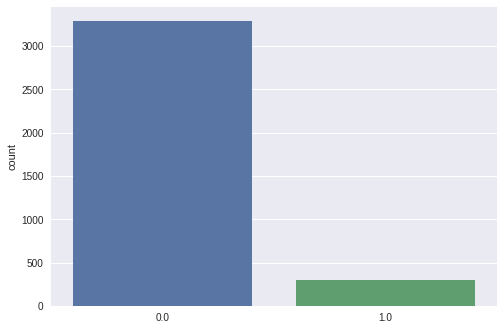

In [179]:
sns.countplot(Y[:, 15])

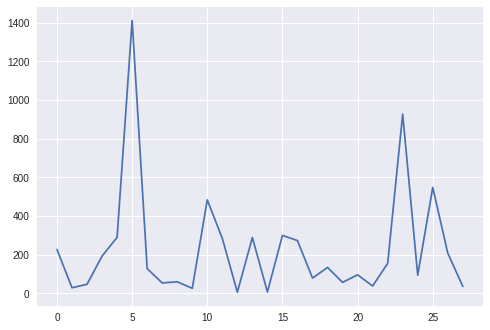

In [180]:
plt.plot(counts)

In [0]:
indexes = []
labels_new = []
counts_new = []

for i in range(len(labels)):
    if counts[i] > 50:
        labels_new.append(labels[i])
        counts_new.append(counts[i])
        indexes.append(i)
        
Y = Y[:, indexes]
labels = labels_new
counts = counts_new

In [182]:
print(len(labels))
print(labels)
print()
print(counts)

21
['консультирование', 'бухгалтерия, управленческий учет, финансы предприятия', 'туризм, гостиницы, рестораны', 'продажи', 'автомобильный бизнес', 'высший менеджмент', 'наука, образование', 'информационные технологии, интернет, телеком', 'транспорт, логистика', 'банки, инвестиции, лизинг', 'маркетинг, реклама, pr', 'строительство, недвижимость', 'спортивные клубы, фитнес, салоны красоты', 'медицина, фармацевтика', 'юристы', 'управление персоналом, тренинги', 'рабочий персонал', 'начало карьеры, студенты', 'искусство, развлечения, масс-медиа', 'административный персонал', 'производство']

[226.0, 192.0, 289.0, 1411.0, 127.0, 53.0, 59.0, 483.0, 283.0, 288.0, 299.0, 272.0, 78.0, 133.0, 56.0, 95.0, 154.0, 926.0, 93.0, 547.0, 207.0]


### Vectorize document from siquence of words to one vector

In [183]:
X = [np.mean(i, axis=0) for i in X]
X = np.array(X)
print(X.shape)

(3588, 300)



[7]
['Производство', 'Закупки']


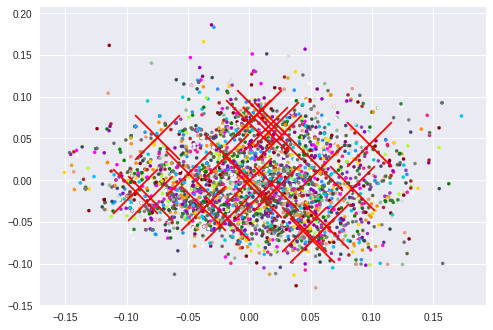

In [185]:
true_k = 21
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X_vect)

#print("Top terms per cluster:")
#order_centroids = model.cluster_centers_.argsort()[:, ::-1]
#terms = [i for i in range(300)]
#for i in range(true_k):
#    print("Cluster %d:" % i)
#    for ind in order_centroids[i, :10]:
#        print(' %s' % terms[ind])
#    print()
    
print()
print(model.predict(X[0].reshape((1, -1))))
print(dataset_hh.loc[0, "profarea_names"])

col_list = list(colors.cnames.keys())
#print(len(col_list))

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=col_list[28:56], s=10)

centers2D = pca.transform(model.cluster_centers_)
plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=2000, linewidths=3, c='r', )
plt.show()            

### Data split

In [186]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=100)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2511, 300)
(1077, 300)
(2511, 21)
(1077, 21)


### 1 vs All classification

In [0]:
classes_weights = []
max_count = max(counts_new)
for i in range(len(counts_new)):
    weight = max_count / counts_new[i] 
    classes_weights.append(weight)

classes_weights = [classes_weights]  
print(classes_weights) 
print(len(classes_weights))

In [266]:
%%time
classif_list = []
train_score_list, test_score_list = [], []

# Training
for i in range(len(labels)):
  num_pos = np.sum(Y_train[:, i])
  num_neg = len(Y_train[:, i]) - num_pos
  sample_weights = np.ones(Y_train[:, i].shape)
  sample_weights[Y_train[:, i] == 1] = num_neg / num_pos
  
  y_train_for_label = Y_train[:, i]
  #new_classifier = LogisticRegression()
  #new_classifier = RandomForestClassifier(n_estimators=80, max_depth=5)
  #new_classifier = GradientBoostingClassifier(n_estimators=80, max_depth=3)
  #new_classifier = GaussianNB()
  #new_classifier = SVC(C=0.5)
  #new_classifier = MLPClassifier()
  new_classifier.fit(X_train, y_train_for_label)
  classif_list.append(new_classifier)
  #sample_weight=sample_weights
  print("Training for class ", i, labels[i], "... Weight for class =", num_neg / num_pos)

Training for class  0 консультирование ... Weight for class = 15.966216216216216


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training for class  1 бухгалтерия, управленческий учет, финансы предприятия ... Weight for class = 18.46511627906977
Training for class  2 туризм, гостиницы, рестораны ... Weight for class = 10.90047393364929
Training for class  3 продажи ... Weight for class = 1.53125
Training for class  4 автомобильный бизнес ... Weight for class = 26.9
Training for class  5 высший менеджмент ... Weight for class = 82.7
Training for class  6 наука, образование ... Weight for class = 54.8
Training for class  7 информационные технологии, интернет, телеком ... Weight for class = 6.1335227272727275
Training for class  8 транспорт, логистика ... Weight for class = 11.876923076923077
Training for class  9 банки, инвестиции, лизинг ... Weight for class = 10.733644859813085
Training for class  10 маркетинг, реклама, pr ... Weight for class = 11.618090452261306
Training for class  11 строительство, недвижимость ... Weight for class = 13.106741573033707
Training for class  12 спортивные клубы, фитнес, салоны к

In [267]:
# Test & display results
for i in range(len(labels)):
    classif = classif_list[i]
    #train_score = float('{0:.3f}'.format(classif.score(X_train, Y_train[:,i])))
    #test_score = float('{0:.3f}'.format(classif.score(X_test, Y_test[:,i])))
    predict = classif.predict(X_train)
    train_score = float('{0:.3f}'.format(metrics.f1_score(Y_train[:,i], predict)))
    predict = classif.predict(X_test)
    test_score = float('{0:.3f}'.format(metrics.f1_score(Y_test[:,i], predict)))
    
    train_score_list.append(train_score)
    test_score_list.append(test_score)
    print('Detecting {} with {}% accuracy (training {}%)'.format(labels[i],
                                                                 100*test_score,
                                                                 100*train_score))

print()
print('Mean f1 score: testing {}, training {}'.format(np.mean(test_score_list),
                                                     np.mean(train_score_list)))
    
predict_train = np.zeros_like(Y_train)
predict_test = np.zeros_like(Y_test)
for i in range(len(labels)):
    classif = classif_list[i]
    predict_train[:,i] = classif.predict(X_train)
    predict_test[:,i] = classif.predict(X_test)
acc_train = 1 - np.sum(np.abs(predict_train - Y_train))/(Y_train.shape[0]*Y_train.shape[1])
acc_test = 1 - np.sum(np.abs(predict_test - Y_test))/(Y_test.shape[0]*Y_test.shape[1])
print('###')
print('Global accuracy: testing {}, training {}'.format(acc_test, acc_train))

well_labeled = 0
for i in range(len(Y_train)):
    if np.sum(np.abs(Y_train[i,:] - predict_train[i,:])) == 0:
        well_labeled +=1
print('Overall {} out of the {} training samples were well labeled'.format(well_labeled,len(Y_train)))

well_labeled = 0
for i in range(len(Y_test)):
    if np.sum(np.abs(Y_test[i,:] - predict_test[i,:])) == 0:
        well_labeled +=1
print('Overall {} out of the {} testing samples were well labeled'.format(well_labeled,len(Y_test)))

Detecting консультирование with 0.0% accuracy (training 0.0%)
Detecting бухгалтерия, управленческий учет, финансы предприятия with 39.0% accuracy (training 51.1%)
Detecting туризм, гостиницы, рестораны with 68.10000000000001% accuracy (training 74.5%)
Detecting продажи with 80.9% accuracy (training 84.3%)
Detecting автомобильный бизнес with 32.7% accuracy (training 37.2%)
Detecting высший менеджмент with 0.0% accuracy (training 0.0%)
Detecting наука, образование with 0.0% accuracy (training 0.0%)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Detecting информационные технологии, интернет, телеком with 70.19999999999999% accuracy (training 70.89999999999999%)
Detecting транспорт, логистика with 71.6% accuracy (training 75.8%)
Detecting банки, инвестиции, лизинг with 71.5% accuracy (training 73.4%)
Detecting маркетинг, реклама, pr with 39.1% accuracy (training 50.2%)
Detecting строительство, недвижимость with 59.4% accuracy (training 71.2%)
Detecting спортивные клубы, фитнес, салоны красоты with 47.599999999999994% accuracy (training 65.2%)
Detecting медицина, фармацевтика with 60.6% accuracy (training 70.7%)
Detecting юристы with 52.2% accuracy (training 69.69999999999999%)
Detecting управление персоналом, тренинги with 6.1% accuracy (training 31.6%)
Detecting рабочий персонал with 42.9% accuracy (training 59.199999999999996%)
Detecting начало карьеры, студенты with 23.1% accuracy (training 32.1%)
Detecting искусство, развлечения, масс-медиа with 0.0% accuracy (training 0.0%)
Detecting административный персонал with 55.7% ac

Log reg - Mean f1 score: testing 0.3923809523809524, training 0.4028095238095238

Random forest (default) - Mean f1 score: testing 0.40671428571428575, training 0.9166666666666665

Random forest (n_est=30, max_depth=3) - Mean f1 score: testing 0.48714285714285716, training 0.6254285714285716

Random forest (n_est=30, max_depth=5) - Mean f1 score: testing 0.5288095238095236, training 0.8464285714285713

Random forest (n_est=30, max_depth=7) - Mean f1 score: testing 0.5265238095238095, training 0.9252857142857144

Random forest (n_est=30, max_depth=9) - Mean f1 score: testing 0.4854285714285715, training 0.9510952380952379

Random forest (n_est=40, max_depth=5) - Mean f1 score: testing 0.5297619047619048, training 0.8522380952380951

Random forest (n_est=60, max_depth=5) - Mean f1 score: testing 0.5395714285714286, training 0.8646190476190474

Random forest (n_est=80, max_depth=5) - Mean f1 score: testing 0.5463809523809524, training 0.8645714285714287

Random forest (n_est=100, max_depth=5) - Mean f1 score: testing 0.5424761904761906, training 0.866095238095238 

Random forest (n_est=120, max_depth=5) - Mean f1 score: testing 0.5412857142857144, training 0.8694761904761905

Random forest (n_est=150, max_depth=5) - Mean f1 score: testing 0.5402380952380953, training 0.8681428571428571

GradientBoostingClassifier(n_estimators=80, max_depth=5) - Mean f1 score: testing 0.5571904761904762, training 0.9752380952380952 / time = 3 min

GradientBoostingClassifier(n_estimators=80, max_depth=4) - Mean f1 score: testing 0.5720476190476189, training 0.9719047619047619 

GradientBoostingClassifier(n_estimators=80, max_depth=3)  - Mean f1 score: testing 0.5788095238095239, training 0.9293809523809523 / time = 2 min -----------

GradientBoostingClassifier(n_estimators=80, max_depth=2) - Mean f1 score: testing 0.5351904761904761, training 0.7915238095238095 / time 2 min

GradientBoostingClassifier(n_estimators=30, max_depth=3) - Mean f1 score: testing 0.5093809523809524, training 0.7613333333333333  / time 2 min

GradientBoostingClassifier(n_estimators=100, max_depth=3) - Mean f1 score: testing 0.5757142857142857, training 0.949190476190476

GradientBoostingClassifier(n_estimators=50, max_depth=3) - Mean f1 score: testing 0.5532380952380953, training 0.8664761904761905

GaussianNB() - Mean f1 score: testing 0.35142857142857153, training 0.36628571428571427


### Training

In [0]:
sample_weight = np.ones(Y1.shape)
sample_weight[Y1 == 1] = 5
print(len(sample_weight[sample_weight==5]))

404


In [0]:
Y_train.shape

(2922, 21)

In [0]:
len(labels_new)

21

In [0]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, padding= 'same',
                 activation="relu", input_shape=(max_len, 300)))
model.add(Conv1D(filters=32, kernel_size=3, padding= 'same',
                 activation="relu"))
model.add(MaxPooling1D(pool_size=2))

#model.add(LSTM(10))
model.add(Bidirectional(layer=LSTM(50, dropout=0.3, recurrent_dropout=0.3),
                        input_shape=(max_len, 300)))
model.add(Dense(50, activation="relu", kernel_regularizer=l2(0.1)))
model.add(Dropout(0.5))
model.add(Dense(len(labels_new), activation="sigmoid", kernel_regularizer=l2(0.1)))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"],
              loss_weights=classes_weights)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 300, 32)           28832     
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 300, 32)           3104      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 150, 32)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 100)               33200     
_________________________________________________________________
dense_18 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 21)                1071      
Total para

In [0]:
%%time
model.fit(X_train, Y_train,
          batch_size=64, 
          epochs=3,
          validation_split=0.15,
          verbose=1)


Train on 2483 samples, validate on 439 samples
Epoch 1/3
2483/2483 [==============================] - 51s 21ms/step - loss: 12.7243 - acc: 0.7800 - val_loss: 8.6945 - val_acc: 0.9165
Epoch 2/3
2483/2483 [==============================] - 32s 13ms/step - loss: 7.9821 - acc: 0.8856 - val_loss: 6.1225 - val_acc: 0.9165
Epoch 3/3
2483/2483 [==============================] - 64s 26ms/step - loss: 5.8040 - acc: 0.9028 - val_loss: 4.6906 - val_acc: 0.9165
Wall time: 2min 30s


In [0]:
np.round(model.predict(X_train[0].reshape((1, -1, 300))))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]], dtype=float32)

In [0]:
Y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [0]:
predict = model.predict(X_train)

In [0]:
np.round(predict[:10])

In [0]:
np.sum(np.round(predict))

0.0

In [0]:
%%time
scores = model.evaluate(X_test, Y_test, batch_size=64)
print("Test accuracy: %.2f%%" % (scores[1] * 100))

### Test